In [1]:
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
from clearsky.utilities import make_time_series, lowpass_2d
import s3fs
import cvxpy as cvx
import pandas as pd
import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
TZ_LOOKUP = {
    'America/Anchorage': 9,
    'America/Chicago': 6,
    'America/Denver': 7,
    'America/Los_Angeles': 8,
    'America/New_York': 5,
    'America/Phoenix': 7,
    'Pacific/Honolulu': 10
}
from datetime import datetime

In [2]:
def load_sys(n, local=True):
    if local:
        base = '../data/PVO/'
    if not local:
        base = 's3://pvinsight.nrel/PVO/'
    meta = pd.read_csv('../data/PVO/sys_meta.csv')
    id = meta['ID'][n]
    df = pd.read_csv(base+'PVOutput/{}.csv'.format(id), index_col=0,
                      parse_dates=[0], usecols=[1, 3])
    tz = meta['TimeZone'][n]
    df.index = df.index.tz_localize(tz).tz_convert('Etc/GMT+{}'.format(TZ_LOOKUP[tz]))   # fix daylight savings
    start = df.index[0]
    end = df.index[-1]
    time_index = pd.date_range(start=start, end=end, freq='5min')
    df = df.reindex(index=time_index, fill_value=0)
    print(n, id)
    return df

In [3]:
df = load_sys(200, local=False)

200 21167


In [4]:
days = df.resample('D').max().index[1:-1]
start = days[0]
end = days[-1]
print(start.date(), end.date())

2013-08-05 2017-07-30


In [5]:
end - start

Timedelta('1455 days 00:00:00')

In [7]:
D = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')
ics = IterativeClearSky(D, k=4, auto_fix_time_shifts=False)

In [8]:
print(ics.fixedTimeStamps)

False


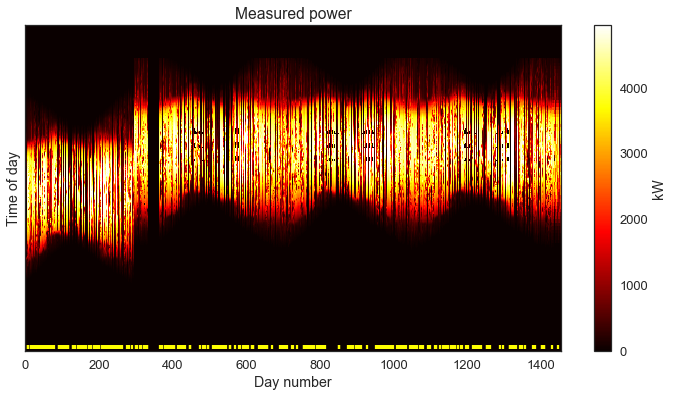

In [9]:
_ = ics.plot_D(show_days=True)

In [10]:
ics = IterativeClearSky(D, k=4)

In [11]:
print(ics.fixedTimeStamps)

True


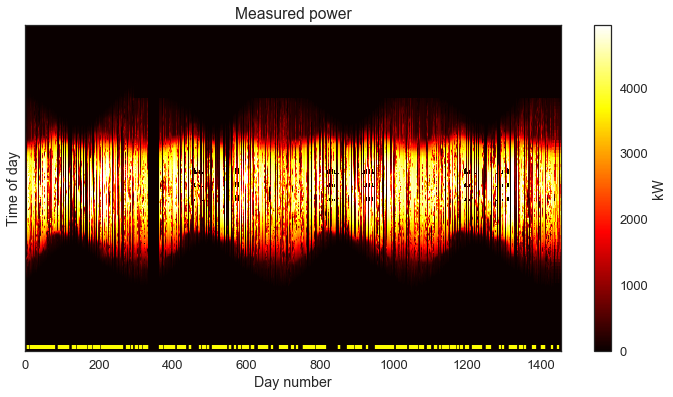

In [12]:
_ = ics.plot_D(show_days=True)

/Users/bennetmeyers/.virtualenvs/clearsky/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


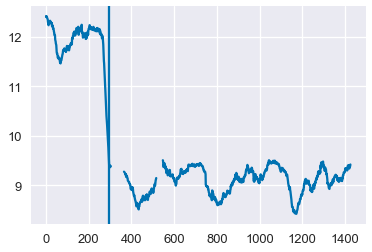

In [9]:
w = 30
sc = 20
s1 = np.convolve(np.divide(np.dot(np.linspace(0, 24, D.shape[0]), D), np.sum(D, axis=0)), np.ones(w), mode='valid') / w
plt.plot(range(len(s1)), s1)
plt.axvline(293)

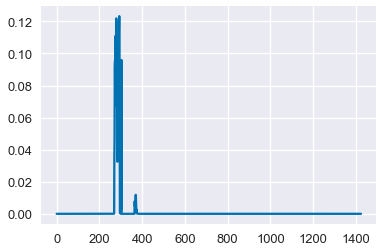

In [10]:
x = cvx.Variable(len(s1))
mu = cvx.Constant(10)
obj = cvx.Minimize(cvx.norm(s1[np.isfinite(s1)] - x[np.isfinite(s1)]) + mu * cvx.norm1(x[:-1] - x[1:]))
prob = cvx.Problem(obj)
prob.solve(solver='MOSEK')
s2 = x.value[:-1] - x.value[1:]
plt.plot(range(len(s2)), s2)

In [11]:
from clearsky.utilities import edge_find_1D, fix_time_shifts

In [12]:
edge_find_1D(s1)

[282]

../clearsky/utilities.py:207: RuntimeWarning: invalid value encountered in true_divide
  s1 = np.divide(np.dot(np.linspace(0, 24, D.shape[0]), D), np.sum(D, axis=0))


2 segments found
index locations:  [297]


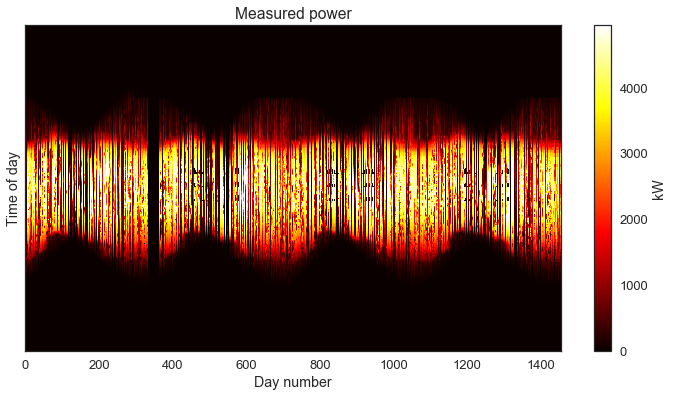

In [13]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(fix_time_shifts(D, verbose=True), cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')

/Users/bennetmeyers/.virtualenvs/clearsky/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


[275, 986]


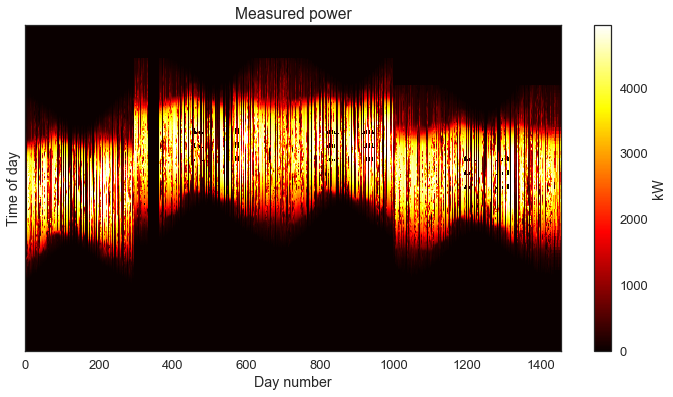

In [44]:
D_roll = np.roll(D, 2*12, axis=0)
Dprime = np.copy(D)
Dprime[:, 1000:] = D_roll[:, 1000:]

w = 30
s1 = np.convolve(np.divide(np.dot(np.linspace(0, 24, Dprime.shape[0]), Dprime), np.sum(Dprime, axis=0)), np.ones(w), mode='valid') / w
ixs = edge_find_1D(s1, tol=1e-1)
print(ixs)
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(Dprime[:, :], cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')

../clearsky/utilities.py:207: RuntimeWarning: invalid value encountered in true_divide
  s1 = np.divide(np.dot(np.linspace(0, 24, D.shape[0]), D), np.sum(D, axis=0))


3 segments found
index locations:  [290, 1001]


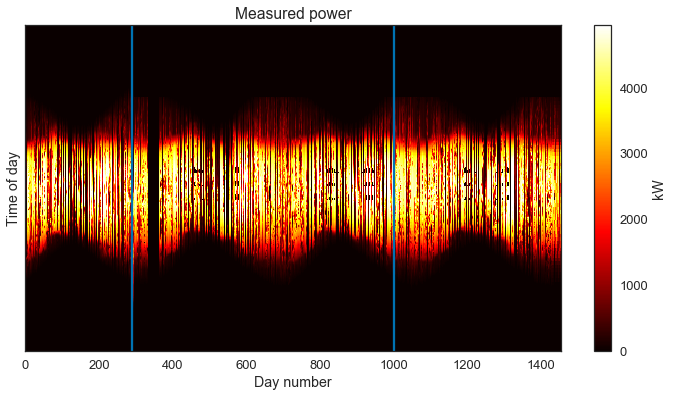

In [15]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(fix_time_shifts(Dprime[:, :], verbose=True), cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    for i in ixs:
        ax.axvline(i + w/2)

In [16]:
U, Sig, Vt = np.linalg.svd(D, full_matrices=False)
U[:, 0] *= -1
Vt[0] *= -1

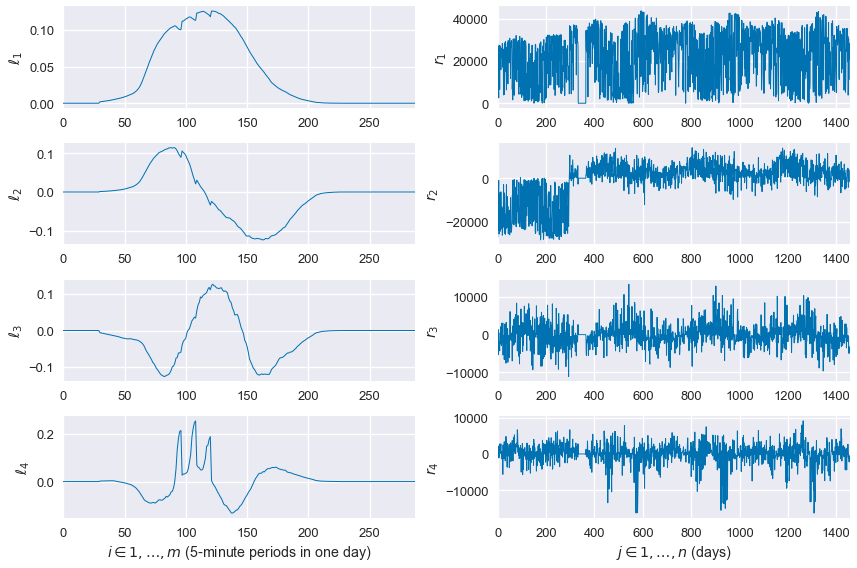

In [17]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,8))
for i in range(4):
    ax[i][0].plot(U.T[i], linewidth=1)
    ax[i][0].set_xlim(0, 287)
    ax[i][0].set_ylabel('$\\ell_{}$'.format(i+1))
    ax[i][1].plot((np.diag(Sig).dot(Vt))[i], linewidth=1)
    ax[i][1].set_xlim(0, D.shape[1])
    ax[i][1].set_ylabel('$r_{}$'.format(i+1))
ax[-1][0].set_xlabel('$i \\in 1, \\ldots, m$ (5-minute periods in one day)')
ax[-1][1].set_xlabel('$j \\in 1, \\ldots, n$ (days)')
plt.tight_layout()
plt.show()

In [18]:
ics = IterativeClearSky(D, k=4)

In [19]:
ics.mu_L = 1e5
ics.mu_R = 1e3
ics.tau = 0.9
import cvxpy as cvx
try:
    ics.minimize_objective(eps=5e-3, max_iter=10, min_deg=None, max_deg=None)
except cvx.SolverError:
    print('solver failed!')

starting at 1497388622.675 [5295545.221692858, 47812.050839906326, 1073922330.3366728, 418122935.0659721]
iteration 1: 7364363.069 [7.20234006e+06 3.50430800e+03 1.58488526e+05 3.01730000e+01]
iteration 2: 6350235.837 [6.14937860e+06 9.26916800e+03 1.91588063e+05 9.00000000e-03]
iteration 3: 6235841.751 [5.99828158e+06 9.51067100e+03 2.28049487e+05 1.60000000e-02]
iteration 4: 6098021.669 [5.82809270e+06 9.78210100e+03 2.60146855e+05 1.10000000e-02]
iteration 5: 6002709.429 [5.71644692e+06 1.05835840e+04 2.75678917e+05 1.00000000e-02]
iteration 6: 5925651.392 [5.64119793e+06 1.11557920e+04 2.73297648e+05 2.70000000e-02]
iteration 7: 5840974.466 [5.56398178e+06 1.10759880e+04 2.65916670e+05 2.40000000e-02]
iteration 8: 5685343.114 [5.43244624e+06 1.10170020e+04 2.41879832e+05 3.90000000e-02]
iteration 9: 5333835.811 [5.13294145e+06 1.00681620e+04 1.90826114e+05 9.00000000e-02]
iteration 10: 4763474.238 [4.61449334e+06 9.78062700e+03 1.39200269e+05 3.00000000e-03]
Reached iteration limit

In [20]:
clearsky = ics.L_cs.value.dot(ics.R_cs.value)
m = clearsky != 0
residuals = np.divide(clearsky[m] - ics.D[m], clearsky[m])
print(np.linalg.norm(residuals))

3351.244831559549


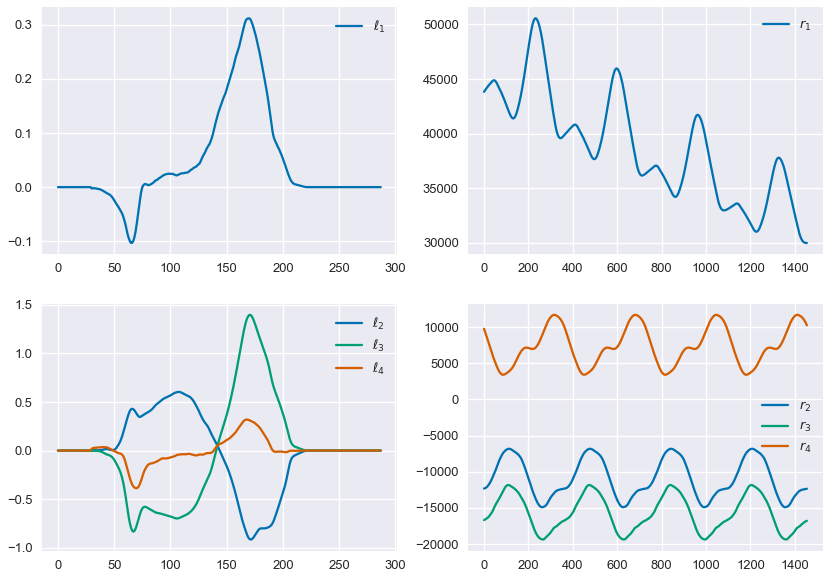

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(ics.R_cs.value[0])
ax[1, 1].plot(ics.R_cs.value[1:].T)
ax[0, 0].plot(ics.L_cs.value[:, 0])
ax[1, 0].plot(ics.L_cs.value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
plt.show()

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [22]:
ics.beta.value

array(-0.09011882)

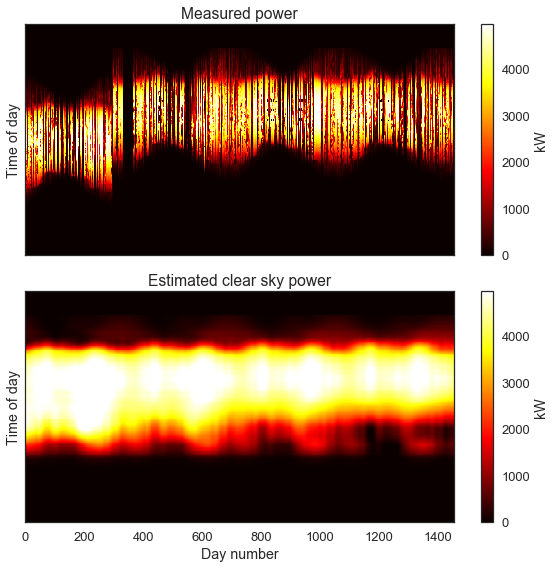

In [23]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,8), sharex=True)
    foo = ax[0].imshow(ics.D, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot',
                       vmin=0, vmax=np.max(ics.D), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW')
    plt.colorbar(bar, ax=ax[1], label='kW')
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

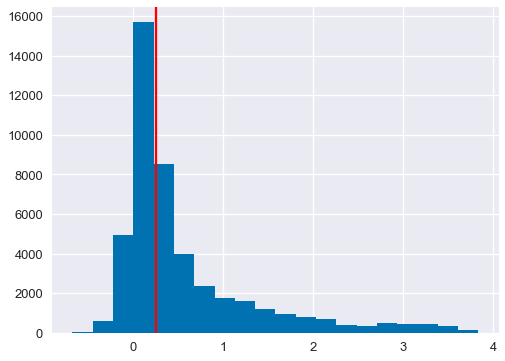

0.2545334654048807 0.7804213949970611


In [24]:
# scale residuals by daily weight, which sets many days to zero. 
W1 = np.diag(ics.weights)
wres = np.dot(ics.L_cs.value.dot(ics.R_cs.value) - ics.D, W1)
use_days = np.logical_not(np.isclose(np.sum(wres, axis=0), 0))
scaled_wres = wres[:, use_days] / np.average(ics.D[:, use_days])
final_metric = scaled_wres[ics.D[:, use_days] > 1e-3]
plt.figure(figsize=(8,6))
plt.hist(final_metric, bins=20)
plt.axvline(np.percentile(final_metric, 50), color='r')
plt.show()
print(np.percentile(final_metric, 50), np.std(final_metric))

In [25]:
ics = IterativeClearSky(fix_time_shifts(D, verbose=True), k=4)

../clearsky/utilities.py:207: RuntimeWarning: invalid value encountered in true_divide
  s1 = np.divide(np.dot(np.linspace(0, 24, D.shape[0]), D), np.sum(D, axis=0))


2 segments found
index locations:  [297]


In [26]:
ics.mu_L = 1e5
ics.mu_R = 1e3
ics.tau = 0.9
import cvxpy as cvx
try:
    ics.minimize_objective(eps=5e-3, max_iter=10, min_deg=None, max_deg=None)
except cvx.SolverError:
    print('solver failed!')

starting at 1330548902.361 [3793555.0220996, 60510.06667423653, 1084859854.5562572, 241834982.71604556]
iteration 1: 2108525.598 [1.93953925e+06 2.64554700e+03 1.66340544e+05 2.57000000e-01]
iteration 2: 1801874.823 [1.63171241e+06 6.21916000e+03 1.63943124e+05 1.34000000e-01]
iteration 3: 1772496.214 [1.60088619e+06 6.02440800e+03 1.65585547e+05 6.90000000e-02]
iteration 4: 1758910.276 [1.58676804e+06 6.08254300e+03 1.66059636e+05 6.10000000e-02]
iteration 5: 1750766.930 [1.57810270e+06 6.43953800e+03 1.66224294e+05 3.94000000e-01]
Minimization complete in 4.39 minutes


In [27]:
clearsky = ics.L_cs.value.dot(ics.R_cs.value)
m = clearsky != 0
residuals = np.divide(clearsky[m] - ics.D[m], clearsky[m])
print(np.linalg.norm(residuals))

22636.497757779223


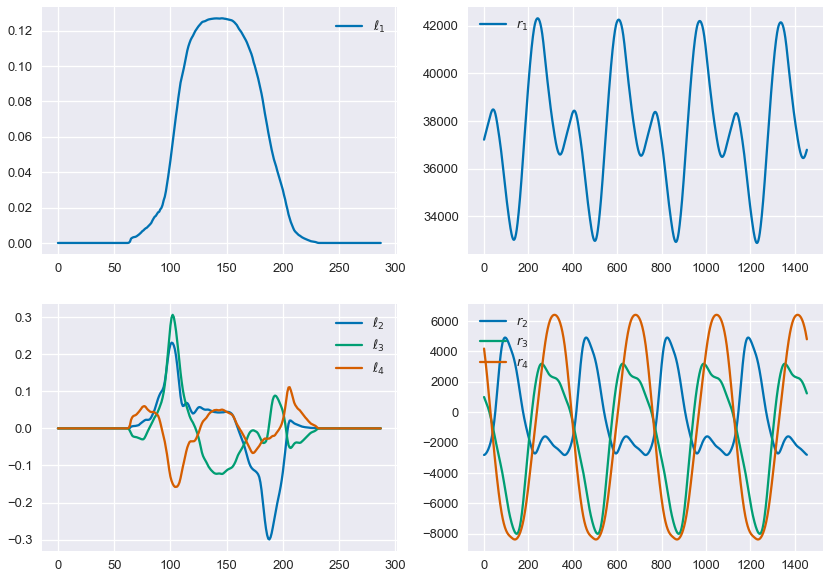

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(ics.R_cs.value[0])
ax[1, 1].plot(ics.R_cs.value[1:].T)
ax[0, 0].plot(ics.L_cs.value[:, 0])
ax[1, 0].plot(ics.L_cs.value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
plt.show()

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [29]:
ics.beta.value

array(-0.00133549)

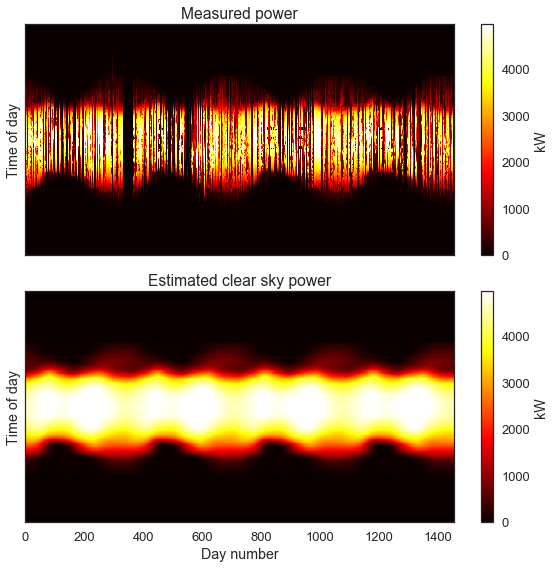

In [30]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,8), sharex=True)
    foo = ax[0].imshow(ics.D, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot',
                       vmin=0, vmax=np.max(ics.D), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW')
    plt.colorbar(bar, ax=ax[1], label='kW')
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

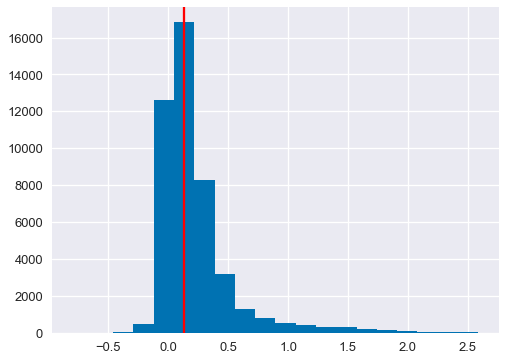

0.13445906603709018 0.3157725083900425


In [31]:
# scale residuals by daily weight, which sets many days to zero. 
W1 = np.diag(ics.weights)
wres = np.dot(ics.L_cs.value.dot(ics.R_cs.value) - ics.D, W1)
use_days = np.logical_not(np.isclose(np.sum(wres, axis=0), 0))
scaled_wres = wres[:, use_days] / np.average(ics.D[:, use_days])
final_metric = scaled_wres[ics.D[:, use_days] > 1e-3]
plt.figure(figsize=(8,6))
plt.hist(final_metric, bins=20)
plt.axvline(np.percentile(final_metric, 50), color='r')
plt.show()
print(np.percentile(final_metric, 50), np.std(final_metric))

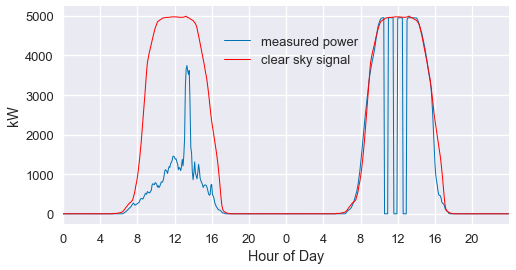

In [32]:
D1 = 570
D2 = D1 + 2
actual = ics.D[:, D1:D2].ravel(order='F')
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(D2-D1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

In [33]:
print(sum(ics.L_cs.shape) + sum(ics.R_cs.shape))

1751


(0, 1440)

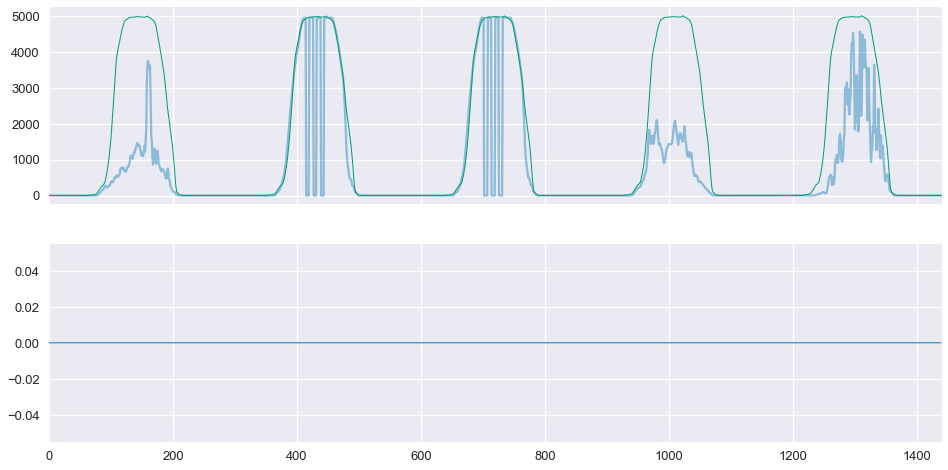

In [34]:
D1 = 570
D2 = D1+5
actual = ics.D[:, D1:D2].ravel(order='F')
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(ics.weights[D1:D2], 288), linewidth=1)
ax[1].set_xlim(0, 288*(D2-D1))

In [35]:
ics.beta.value

array(-0.00133549)

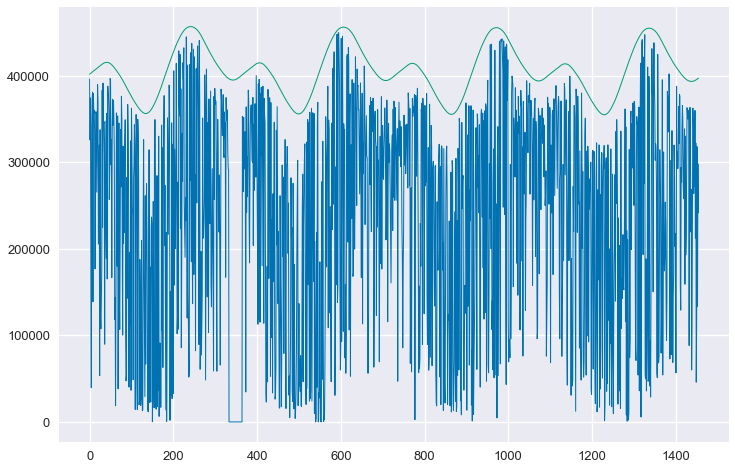

In [36]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(D, axis=0), linewidth=1)
plt.plot(ics.R_cs.value[0] * np.sum(ics.L_cs.value[:, 0]), linewidth=1)

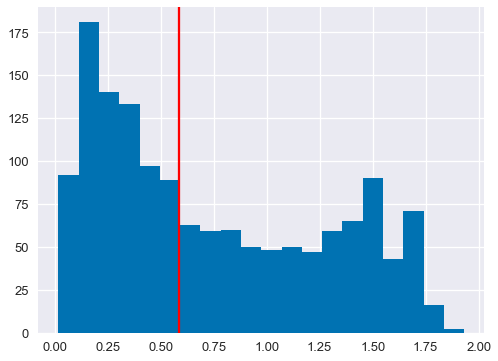

0.5875136837363208


In [37]:
residuals1 = (ics.R_cs.value[0] * np.sum(ics.L_cs.value[:, 0]) - np.sum(D, axis=0)) / np.average(np.sum(D, axis=0))
plt.figure(figsize=(8,6))
plt.hist(residuals1, bins=20)
plt.axvline(np.percentile(residuals1, 50), color='r')
plt.show()
print(np.percentile(residuals1, 50))

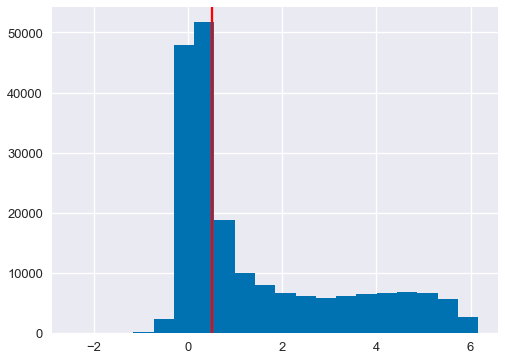

0.5225829914075655


In [38]:
residuals2 = ((ics.L_cs.value.dot(ics.R_cs.value) - ics.D) / np.average(ics.D))[ics.D > 1e-3]
plt.figure(figsize=(8,6))
plt.hist(residuals2, bins=20)
plt.axvline(np.percentile(residuals2, 50), color='r')
plt.show()
print(np.percentile(residuals2, 50))

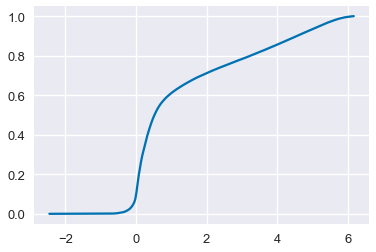

In [39]:
plt.plot(np.sort(residuals2), np.linspace(0, 1, len(residuals2), endpoint=False))

In [40]:
np.save('good_quantiles.npy', np.percentile(residuals2, np.arange(2, 99, 2)))

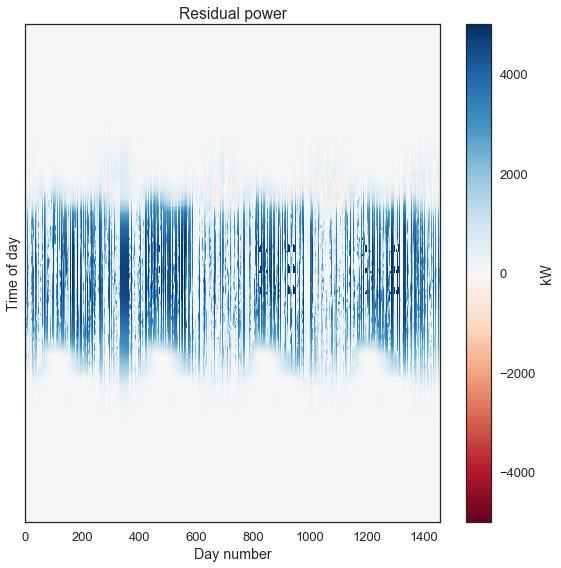

In [41]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(8,8), sharex=True)
    r = ics.L_cs.value.dot(ics.R_cs.value) - ics.D
    val = np.max([np.abs(np.min(r)), np.abs(np.max(r))])
    foo = ax.imshow(r, cmap='RdBu', interpolation='none', aspect='auto', vmin=-val, vmax=val)
    #plt.colorbar(label='kW')
    ax.set_title('Residual power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    plt.tight_layout()

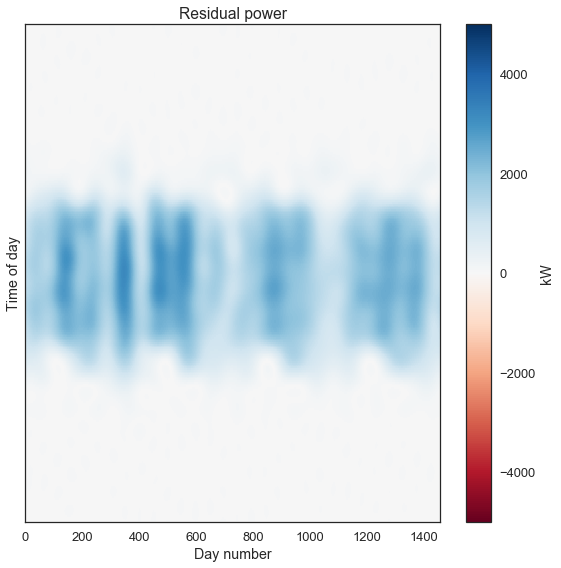

In [42]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(8,8), sharex=True)
    r = ics.L_cs.value.dot(ics.R_cs.value) - ics.D
    val = np.max([np.abs(np.min(r)), np.abs(np.max(r))])
    foo = ax.imshow(lowpass_2d(r, r=15), cmap='RdBu', interpolation='none', aspect='auto', vmin=-val, vmax=val)
    #plt.colorbar(label='kW')
    ax.set_title('Residual power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    plt.tight_layout()

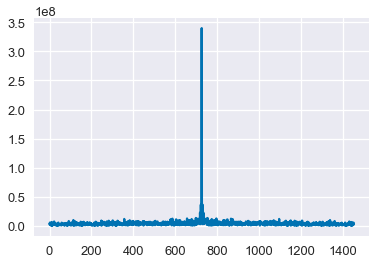

In [43]:
a = np.fft.fft2(ics.D)[0]
plt.plot(np.abs(np.fft.fftshift(a)))